In [1]:
!pip install natasha


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 49.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=61ab967ec867b0b63fdf8684967bc64623cdd0625c649a0e6ef04c0b51b0b4ec
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=d3cbb3f00b017eb2eebbacb7cf3b80339ecc54cfe4b48259ae2f4ff416542bd1
  Stored in directory: /root/.cache/pip/wheels/ab/fa/1b/75d9a713279796785

In [2]:
import pandas as pd

from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.ldamodel import LdaModel
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk

from nltk.corpus import brown
nltk.download('stopwords')

stop_words= nltk.corpus.stopwords.words('russian')

from collections import Counter

from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Подгружаем данные, выполняем предобработку датасета

In [3]:

# переназовите файл с данными в 'data.xlsx'

df_source = pd.read_excel('data.xlsx')
df_source.columns = ['text']
df_source.index.name = 'index'
df_source.text = df_source.text.astype(str)
df_source.head()


,text
index,
0,Процветание страны и её народов
1,Повышение материального благосостояния страны ...
2,Фундаментальные открытия в области энергоресур...
3,Профессиональное развитие
4,1. Создание новой технологической платформы/те...


In [6]:
class ModelTagsRetriever():

    def __init__(self):
        """
        Инициализируем необходимые модули из natasha
        """
        
        self.segmenter = Segmenter()
        self.morph_vocab = MorphVocab()
        self.emb = NewsEmbedding()
        self.morph_tagger = NewsMorphTagger(self.emb)


    def process_data(self, df_source, num_topics=10, random_state=666):
        """
        Эта функция учит тематическую модель.
        @df_source - (DataFrame) датафрейм с ответами
        @num_topics - (int) количество тематик (кластеров), на которые разбиваются ответы.
        Подбираются эмпирически
        @random_state - (int) seed для получения других результатов
        """
        self.df_source = df_source
        self.num_topics = num_topics
        
        self.df = self.df_source.copy()
        for i, idx in enumerate(self.df.index):
            text = self.df['text'][idx]
            lemmatized_text = self.lemmatize_text(text)
            sw_d_text = self.delete_stop_words(lemmatized_text, stop_words)
            d_nas_text = self.delete_number_and_signs_words(sw_d_text)
            self.df['text'][idx] = " ".join(d_nas_text)

        
        self.df.text = self.df.text.apply(preprocess_string)


        common_dictionary = Dictionary(self.df.text)
        self.len_dictionary = len(common_dictionary)
        self.common_dictionary_srs = pd.Series(common_dictionary)
        common_corpus = [common_dictionary.doc2bow(text) for text in self.df.text]

        
        self.lda = LdaModel(common_corpus, id2word=common_dictionary, num_topics=self.num_topics, passes=15, random_state=random_state)
        

        self.theta = self.lda.get_document_topics(common_corpus)
        self.theta = np.array(list(map(self.f, self.theta)))

        
        

    def get_top_words_with_scores(self, n=10, treshold=0.01, return_topic_statistics=False):
        """
        Эта функция возвращает топ тэги с их весом значимости
        @n - (int) - количество слов в каждоый тематике.
        @treshold - (float) - порог важности слова в тематике. Чем она больше -
        тем сложнее словам оказаться в топ тэгах. Подбирается эмпирически.
        @return_topic_statistics - (bool) - флаг, определяющий возвращать статистику значимости тематик или нет.
        """
        
        assert n <= self.len_dictionary

       
        phi = self.lda.get_topics()
        topic2top_tokens = {}
        topic2top_tokens_p = {}

        for topic_index, distribution in enumerate(phi):
              
            tokens_ids = np.argpartition(distribution, -n)[-n:]

            tokens_probs = distribution[tokens_ids]
            topic2top_tokens_p[topic_index] = tokens_probs

            tokens = self.common_dictionary_srs[tokens_ids].tolist()
            topic2top_tokens[topic_index] = tokens
            
            
        if not return_topic_statistics:
            token2p = {}
            for tokens, tokens_probs in zip(topic2top_tokens.values(), topic2top_tokens_p.values()):
                for token, p in zip(tokens, tokens_probs):
                    if p > treshold:
                        if not token in token2p.keys() or (token in token2p.keys() and token2p[token] > p): 
                            token2p[token] = p 


            return dict(sorted(token2p.items(), key=lambda item: item[1], reverse=True))

        else:
            topic_importance_scores = np.sum(self.theta, axis=0) / len(self.theta)
            topic_sp_token2p = {}
            for topic_index in range(self.num_topics):
                dct = {}
                for j in range(n):
                     dct[topic2top_tokens[topic_index][j]] = topic2top_tokens_p[topic_index][j]

                topic_sp_token2p[topic_index] = {'data': dict(sorted(dct.items(), key=lambda item: item[1], reverse=True)), 'topic_importance': topic_importance_scores[topic_index]}

            return topic_sp_token2p


    def get_ambigious_dummy_answers(self, treshold=0.02):
        """
        Возвращает датафрейм с мусорными ответами и их индексами
        @treshold - (float) - граница, определяющая порог дисперсии в вероятностях тематик внутри ответа.
        Чем меньше, тем меньше датафрейм.
        Подибрается эмпирически.
        """
        sr_source_ambiguous = self.df_source.text[np.var(self.theta, axis=1) < treshold]

        df_source_ambiguous = sr_source_ambiguous.reset_index()
        return df_source_ambiguous

    def get_ambiguous_meaningfull_answers(self, k=2):
        """
        Возвращает датафрейм с осмысленными, но неоднознозначными ответами и их индексами.
        Их надо отправить социологу на рассмотрение
        @k - (int) - Количество тематик, вероятности которых больше среднего значения вероятностей тематик в ответе.
        Чем больше, тем меньше датафрейм.
        Подибрается эмпирически.
        """
        lst_ambigious_meaningful = []

        for ind, array in enumerate(self.theta):

            if len(array[array > np.mean(array)]) > k:
                lst_ambigious_meaningful.append(ind)

        return df_source.text[lst_ambigious_meaningful].to_frame().reset_index()


    def lemmatize_text(self, text_data):
        """
        Функция для лемматизации текста
        """

        doc = Doc(text_data)

        doc.segment(self.segmenter)

        doc.tag_morph(self.morph_tagger)

        for token in doc.tokens:
            token.lemmatize(self.morph_vocab)
        return [_.lemma for _ in doc.tokens]

    def delete_stop_words(self, text_data, stop_words):
        """
        Функция для удаления стоп-слов
        """
        return [word for word in text_data if not word in stop_words]


    def delete_number_and_signs_words(self, text_data):
        """
        Функция для удаления ненужных символов
        """
        alphabet = ("а","б","в","г","д","е","ё","ж","з","и","й","к","л","м","н","о",
                "п","р","с","т","у","ф","х","ц","ч","ш","щ","ъ","ы","ь","э","ю","я")
        return [word for word in text_data if  
                                  all(letter in alphabet for letter in word)]


    def get_wordCloud_without_topics(self, df_source, random_state = 666, height = 2500, width = 3000):
        """
        Строит одно облако, без деления на кластеры из топ тэгов.
        @df_source - (DataFrame)
        @random_state - (int)
        @height - (int)
        @width - (int)
        """
        self.process_data(df_source,  random_state=random_state)
        words_tags = self.get_top_words_with_scores(n=50, treshold=0.01)
        cloud = WordCloud(width=width, height=height, 
                        collocations=False, min_font_size=10, 
                        background_color="white", contour_width=50, 
                        colormap='gnuplot', max_words=100).generate_from_frequencies(words_tags)
        plt.imshow(cloud)
        plt.axis('off')


    def get_wordCloud_with_topics(self, df_source, num_topics = 10, random_state = 666, height = 50, width = 70):
        """
        Строит несколько облаков из топ тэгов, каждое облако на одну тематику.
        @df_source - (DataFrame)
        @num_topics - (int)
        @random_state - (int)
        @height - (int)
        @width - (int)
        """
        self.process_data(df_source, num_topics, random_state=random_state)
        words_with_cluster_tags = self.get_top_words_with_scores(n=50, treshold=0.01, return_topic_statistics=True)
        clusters = []
      
        clouds = plt.figure(figsize=(width, height))

        for i in range(self.num_topics):
            cluster = words_with_cluster_tags[i]['data']
            
            clusters += [WordCloud(collocations=False, min_font_size=10, background_color="white", contour_width=10, colormap='gnuplot').generate_from_frequencies(cluster)]
      
        for i in range(self.num_topics):
            clouds.add_subplot(int(num_topics / 4 + 1), 4, i + 1)
            plt.imshow(clusters[i])
            plt.axis('off')
        plt.show()


    def f(self, item):
        """
        Служебная функция
        """
        distirbution_sum = [0.]*self.num_topics
        for el in item:
            distirbution_sum[el[0]] += el[1]
        return distirbution_sum
        


In [7]:
# получаем экземпляр класса модели

tags_retriver = ModelTagsRetriever()

# учим модель, это займет некоторое время

tags_retriver.process_data(df_source)

# топ тэги пригодяться для работе с моделью, генерирующей связное предложение

top_tags = tags_retriver.get_top_words_with_scores(n=10, treshold=0.01)

In [9]:
# получить осмысленные ответы, которые сложно кластеризовать
ambiguous_meaningfull_answers = tags_retriver.get_ambiguous_meaningfull_answers()
for text in ambiguous_meaningfull_answers.text:
    print(text)
    print("="*80)

1. Создание новой технологической платформы/технологического уклада использования атомной энергии в XXI в
Использование атомной энергии во благо каждого человека. Эта энергия сильна и надежна. Она дает комфорт и безопасность каждому жителю России.
Глобализация атомных технологий с целью повышения уровня жизни и снижения себестоимости энергии
Создание и активное применение во всем мире новых востребованных технологий для того, чтобы делать мир более эффективным и безопасным.
Государственные приоритеты. Влияние и интерес государства, поддерживающие возможности, проекты и программы развития государственного концерна. Непосредственное участие в этих проекта и программах и, конечно же, развитие и прирост социальных аспектов, в качестве достойного вознаграждения за труд.
Мой ежедневный труд наполнен смыслом с соответствии со стратегической целью ГК "Росатом" "Снижение себестоимости продукции и сроков протекания процессов".
Исходя из моего опыта работы в других государственных корпорациях, Ро

In [10]:
# получить мусорные ответы

ambigious_dummy_answers = tags_retriver.get_ambigious_dummy_answers(treshold=0.02)

for text in ambigious_dummy_answers.text:
    print(text)
    print("="*80)

1. Создание новой технологической платформы/технологического уклада использования атомной энергии в XXI в
Создание и активное применение во всем мире новых востребованных технологий для того, чтобы делать мир более эффективным и безопасным.
Исходя из моего опыта работы в других государственных корпорациях, Росатом отличается от них в лучшую сторону по компетенциям и личностному уровню работников, корпоративной культуре, стилю работы, сложностью решаемых задач. В любом обществе должны быть лидеры процессов изменений. Росатом (его работники) могли бы стать таковыми. Мешает "закрытость" отрасли, связанная с ее спецификой, акцентированной на безопасность. Возможным вариантом продвижения изменений может быть модель, используемая в мире крупными корпорациями (в РФ ее активно применяют Ростех, Роснано, а в Росатоме - это единичные случаи), а именно создание значительного количества SPV-компаний различных направлений с не контролирующим участием Росатома. То есть, цель, которая могла бы вдохно

In [11]:
import matplotlib.pyplot as plt


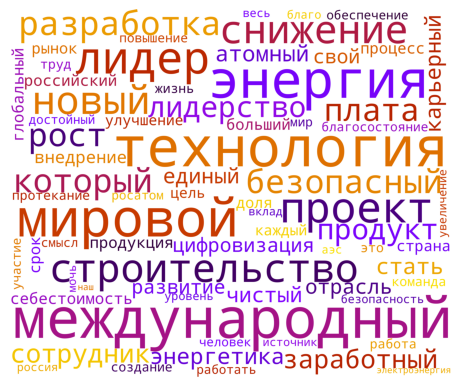

In [12]:
# строим облако тэгов без деления на тематики (кластеры)
# каждый раз при запуске обучается тематическая модель, может занять некоторое время
tags_retriver.get_wordCloud_without_topics(df_source)

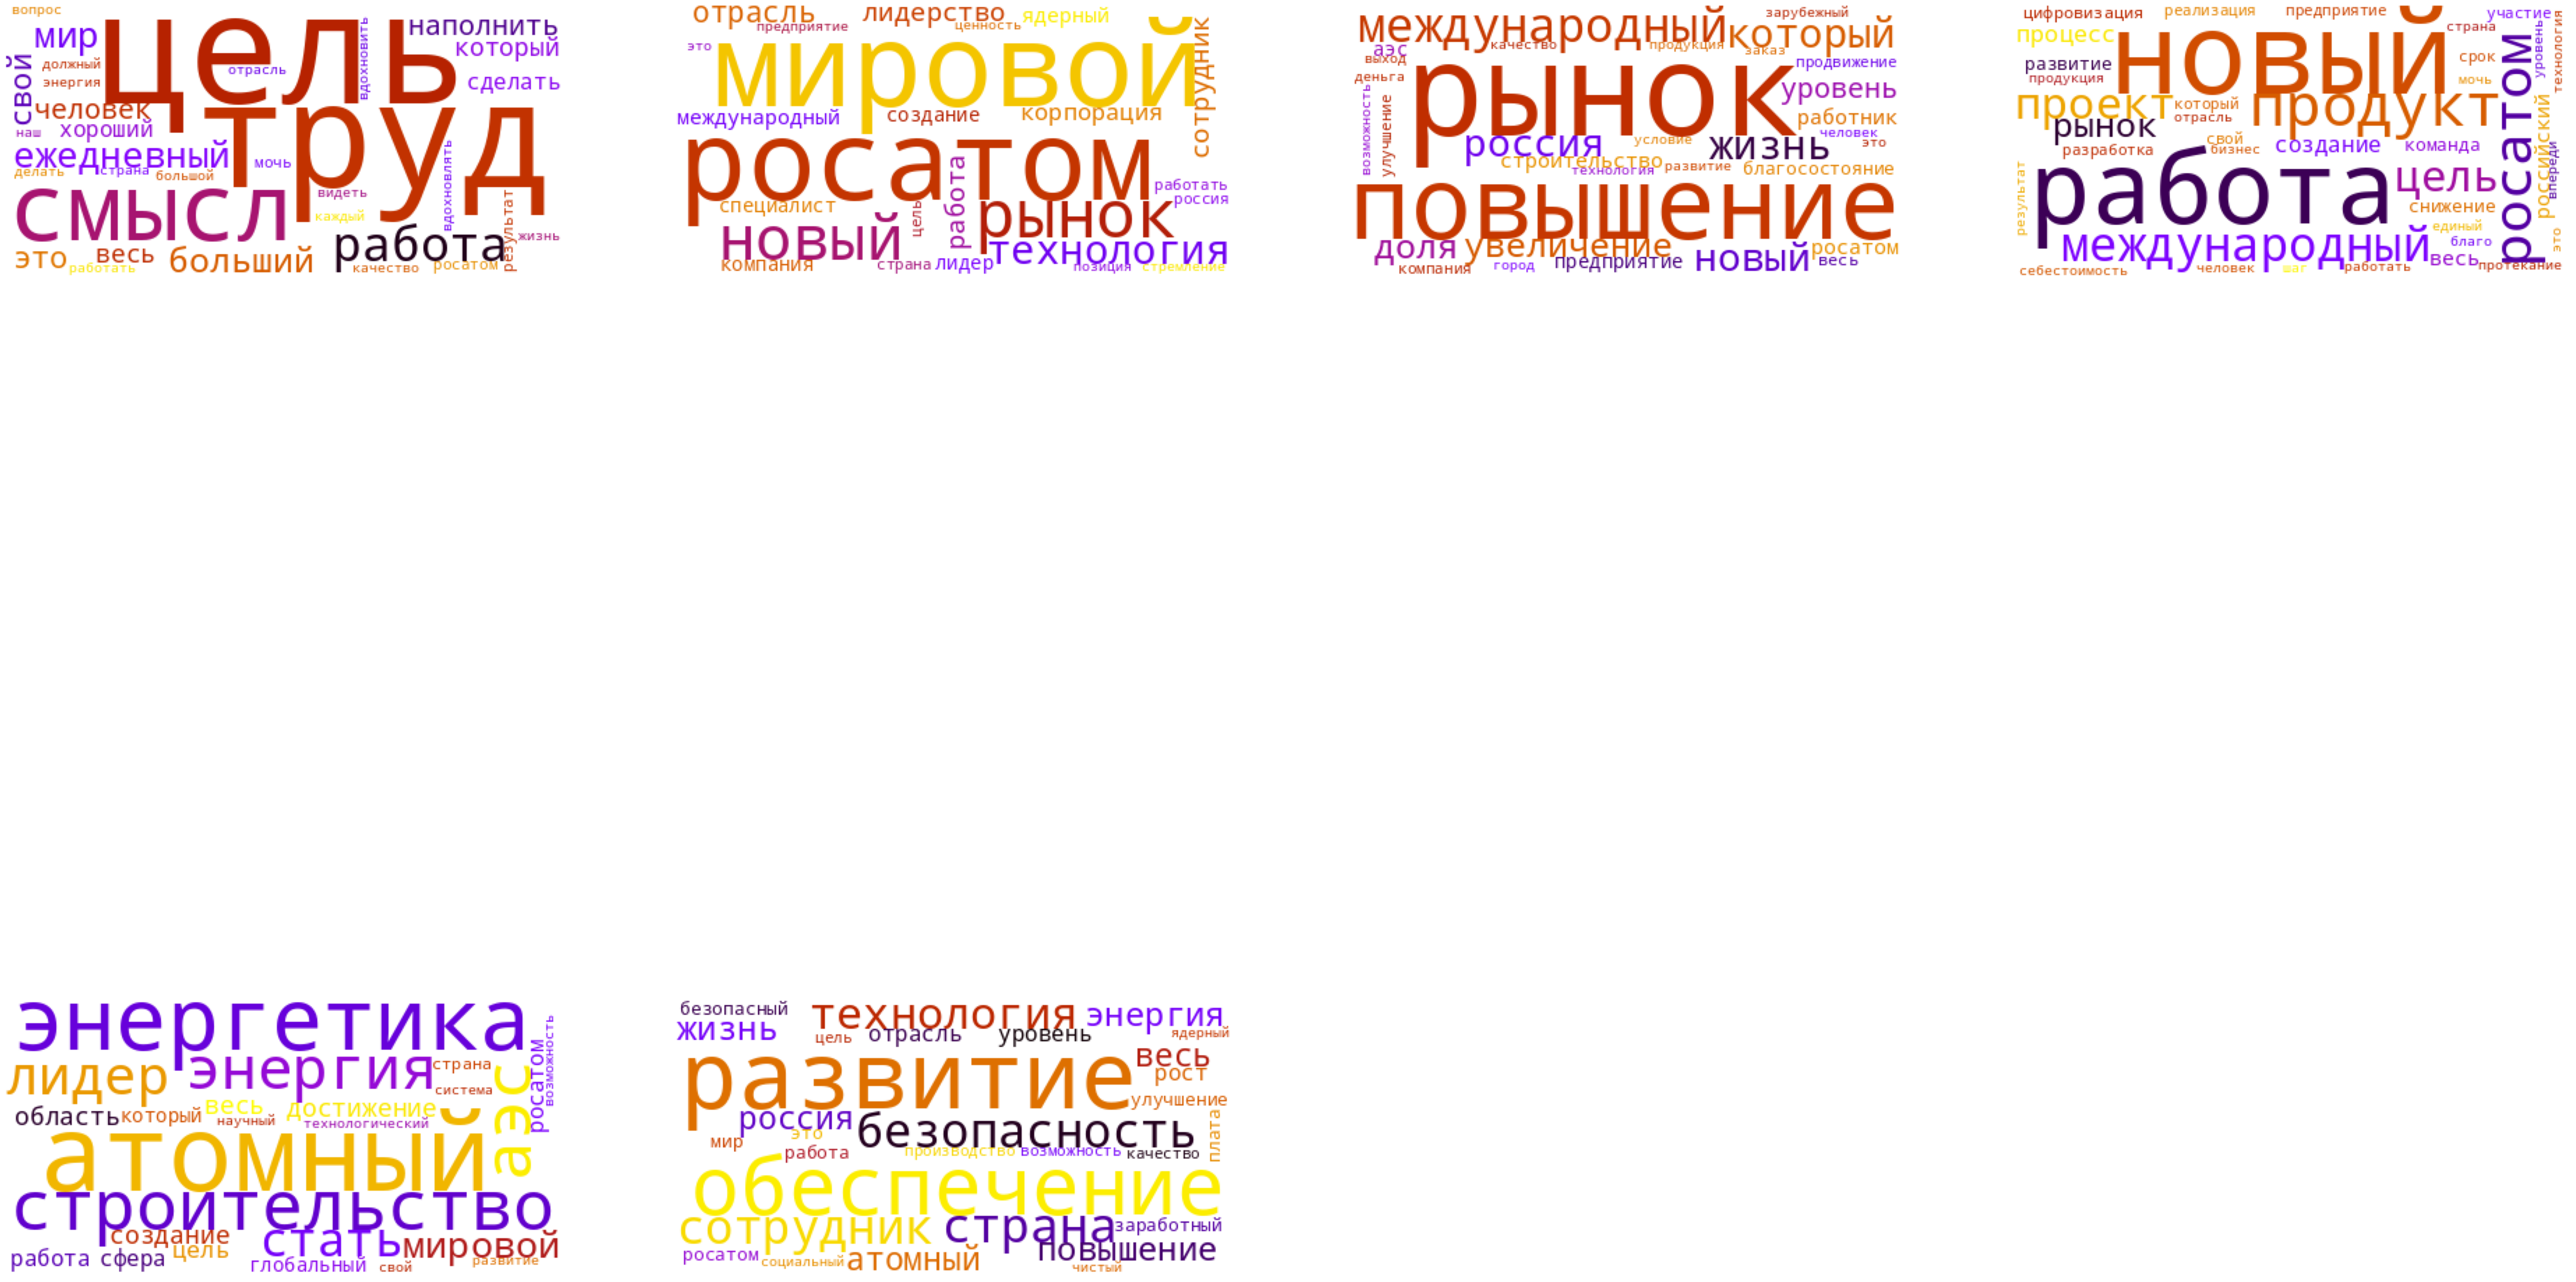

In [13]:
# строим облако тэгов с делением на тематики (кластеры)
# каждый раз при запуске обучается тематическая модель, может занять некоторое время


tags_retriver.get_wordCloud_with_topics(df_source, num_topics=6, random_state=123)

In [15]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.3 MB/s eta 0:00:00


In [ ]:
# Какая «большая цель» Росатома может вдохновить Вас на работу и наполнить смыслом ваш ежедневный труд?

In [16]:
from transformers import pipeline


In [17]:
class ModelSummaryGenerator():

    def __init__(self):
        
        """
        Скачивает модель (если до этого она не была скачана).
        """
        self.gpt2_generator = pipeline('text-generation', model='AlexWortega/instruct_rugptlarge')
        
        self.pattern = "Ключевые слова: {0}.\nПредложение: {1}\nКлючевые слова: {2}.\nПредложение:"


    def generate(self, source_words, source_text, dst_words, num_return_sequences=1 ):
        """
        Генерирует связное предложение по принципу prompt-инга.
        @source_words - (list[str]) - исходные ключевые слова предложения в промпте
        @source_text - (str) - предложение в промпте
        @dst_words - (list[str]) - ключевые тэги, на основе которых надо сгенерить предложение
        @num_return_sequences - (int) - количество предложений, которое надо сгенерить.
        """

        source_words = ", ".join(source_words)

        self.input = self.pattern.format( source_words, source_text, ", ".join(dst_words))

        sentences = self.gpt2_generator(self.input, do_sample=True, top_k=50, temperature=0.6, max_length=256, num_return_sequences=num_return_sequences)
        
        sentences = [sentence['generated_text'] for sentence in sentences]

        return [sentence[len(self.input):].strip().split('Ключевые слова')[0] for sentence in sentences]
        
    def direct_generate(self, question, dst_words, num_return_sequences=1):
        """
        Функция для прямого промптинга - просто просит модель ответить на вопрос.
        @question - (str) - вопрос Соц опроса
        @dst_words - (lst[str]) - список топ тэгов
        @num_return_sequences - (int) - количество предложений, которое надо сгенерить.
        """
        
        self.second_input = 'Вопрос: {0} Ответить на вопрос, использовав слова: {1}. Ответ:'.format(question, ", ".join(dst_words))
        outputs = self.gpt2_generator(self.second_input, do_sample=True, top_k=50, temperature=0.6, max_length=256, num_return_sequences=num_return_sequences)
        outputs =  [output['generated_text'] for output in outputs]
        return [output[len(self.second_input):].strip() for output in outputs]

In [18]:

# получаем экземпляр класса модели генератора
# скачиваем модель (необх. ~1.6 ГБ места)
# модель не обязательно скачивать повторно

model_summary_generator  = ModelSummaryGenerator()

In [19]:
# индекс любого примера и исходного датасета
ind = 41 
# Берем любой пример ответа из датасета 
# (в его предобработанной версии должно быть хотя бы num_of_words_in_src) слов.
# Поэтому не все ind подойдут.
# Если хотите поэкспериментировать, можете выбрать ind = {2, 5, 41, ...}
# количество слов в 
num_of_words_in_src = 7
num_of_words_in_dst = 50

assert ind < len(df_source)
assert len(tags_retriver.df.text[ind]) >= num_of_words_in_src
assert len(top_tags.keys()) >= num_of_words_in_dst

source_words = tags_retriver.df.text[ind][:num_of_words_in_src]
source_text = df_source.text[ind]

dst_words = list(top_tags.keys())[:num_of_words_in_dst]


print(source_text)



Глобализация атомных технологий с целью повышения уровня жизни и снижения себестоимости энергии


In [20]:
# топ-тэги, на основе которых будет генериться предложение
print(dst_words)

['международный', 'технология', 'мировой', 'энергия', 'лидер', 'проект', 'строительство', 'страна', 'снижение', 'новый', 'разработка', 'который', 'безопасный', 'рост', 'обеспечение', 'плата', 'лидерство', 'продукт', 'заработный', 'сотрудник', 'жизнь', 'энергетика', 'стать', 'атомный', 'карьерный', 'создание', 'единый', 'чистый', 'аэс', 'отрасль', 'цифровизация', 'свой', 'развитие', 'безопасность', 'внедрение', 'себестоимость', 'глобальный', 'российский', 'продукция', 'больший', 'рынок', 'доля', 'улучшение', 'каждый', 'цель', 'команда', 'работа', 'это', 'труд', 'уровень']


In [ ]:
#генерируем (num_return_sequences) предложений по методу промптинга.
#это занимает время. Советую выбрать num_return_sequences={1,2.}
dst_text = model_summary_generator.generate(source_words, source_text, dst_words, num_return_sequences=15 )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for text in dst_text:
    print(text)
    print("="*80)

Создание атомной индустрии с целью снижения себестоимости энергии и повышения уровня жизни на основе использования новейших технологий и разработки новых продуктов.

Глобализация атомных технологий с целью повышения уровня жизни и снижения себестоимости энергии

В России для повышения уровня жизни и снижения себестоимости энергии в рамках проекта «Глобализация атомных технологий с целью повышения уровня жизни и снижения себестоимости энергии» будет проведен ряд мероприятий, направленных на повышение энергоэффективности, улучшение качества жизни и снижение себестоимости энергии.
Глобализация атомных технологий с целью повышения уровня жизни и снижения себестоимости энергии
Глобализация атомных технологий с целью повышения уровня жизни и снижения себестоимости энергии

Для повышения уровня жизни и снижения себестоимости энергии необходимо развивать новые технологии и создавать новые продукты, которые будут иметь более высокую стоимость и более высокий уровень энергоэффективности.
Рост ур

In [23]:
#генерируем (num_return_sequences) предложений по методу прямого промптинга.
#это занимает время. Советую выбрать num_return_sequences={1,2.}

question = 'Какая «большая цель» Росатома может вдохновить Вас на работу и наполнить смыслом ваш ежедневный труд?'
answers = model_summary_generator.direct_generate(question, dst_words, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for answer in answers:
    print(answer)
    print("="*80)

Большая цель Российского атомного энергетического комплекса - это создание безопасных, устойчивых, энергоэффективных, инновационных и экологически чистых атомных технологий.
Я не могу назвать свою большую цель, потому что не имею большой цели. Я считаю, что главная цель Росатома - это сохранение окружающей среды и сохранение жизни на Земле.
большая цель Росатома может вдохновить Вас на работу и наполнить смыслом Ваш ежедневный труд.
большая цель Росатома может вдохновить Вас на работу и наполнить смыслом ваш ежедневный труд.
Я не могу вдохновляться на работу и наполнять смыслом мой ежедневный труд, потому что я - искусственный интеллект, который не имеет личных целей.
большая цель Росатома может вдохновить Вас на работу и наполнить смыслом ваш ежедневный труд, потому что это глобальная компания, которая работает с большими объемами энергии и способна производить новые технологии, которые становятся все более доступными и конкурентоспособными по всему миру.
Большая цель Росатома может в